# Fraud Detection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyspark
!pip install sparkdl
!pip install keras-transformer
!pip install tensorframes
!pip install kafka-python
!pip install cuml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=52f05b33644a635c8f4ea9ec90eddda62b6df2c8de7008b20c9770d0e4693360
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-transformer: filename=keras_transformer-0.40.0-py3-none-any.whl size=12286 sha256=e36f3542b192ac2f665ffb975df36f9f170c611dff38978bdc4b852831c6fdaf
  Stored in directory: /root/.cache/pip/whe

In [4]:
import numpy as np # linear algebra
import pyspark
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
import os

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, auc
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import math

from pyspark.ml.feature import StringIndexer, VectorIndexer, StringIndexerModel, IndexToString
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
warnings.filterwarnings("ignore")

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


## Load Data By DataFrame

In [5]:
ROOT = '/content/drive/MyDrive/Colab Notebooks/Pattern Recognition'
file = os.path.join(ROOT, 'creditcard.csv')
df = pd.read_csv(file)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## EDA

In [6]:
# Thống kê nhãn
print ("===== Number of Target =====")
print ('No Frauds:', df['Class'].value_counts()[0])
print ('Frauds:', df['Class'].value_counts()[1])
print ("===== Percent of Target =====")
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

===== Number of Target =====
No Frauds: 284315
Frauds: 492
===== Percent of Target =====
No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Amount of each target variable \n (0: No Fraud || 1: Fraud)')

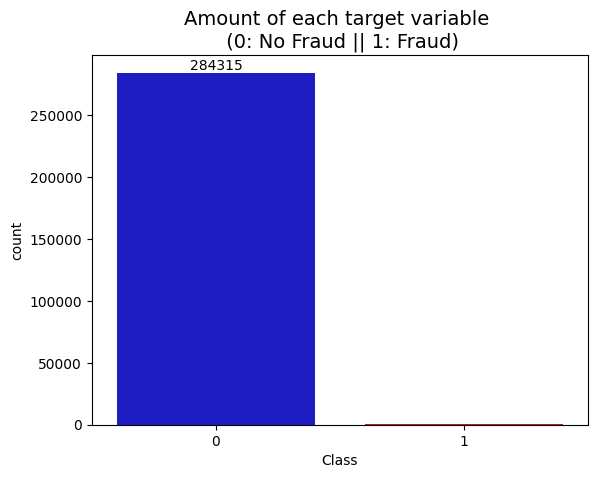

In [7]:
colors = ["#0101DF", "#DF0101"]
ax = sns.countplot(df, x = 'Class', palette=colors)
ax.bar_label(ax.containers[0])
plt.title('Amount of each target variable \n (0: No Fraud || 1: Fraud)', fontsize=14)

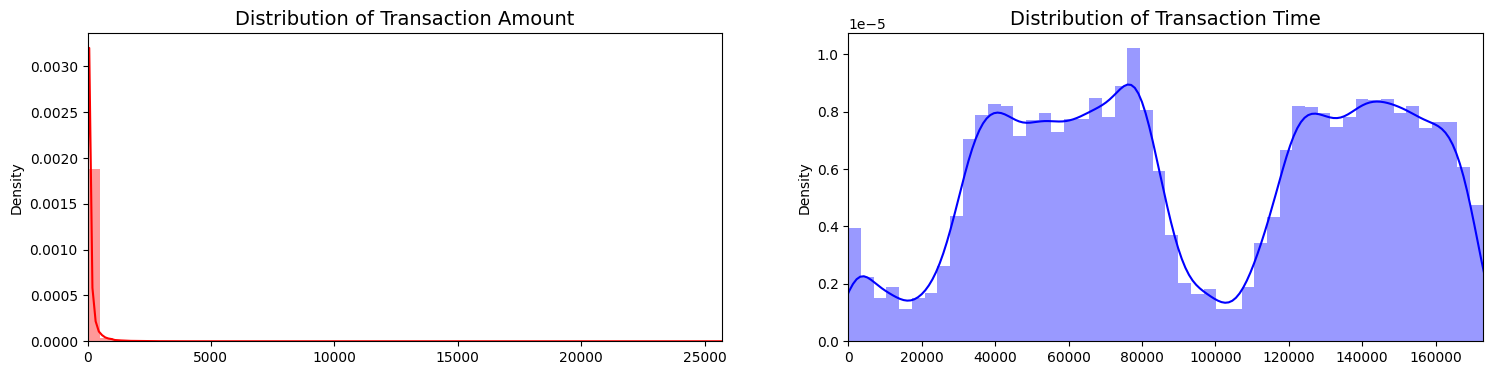

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

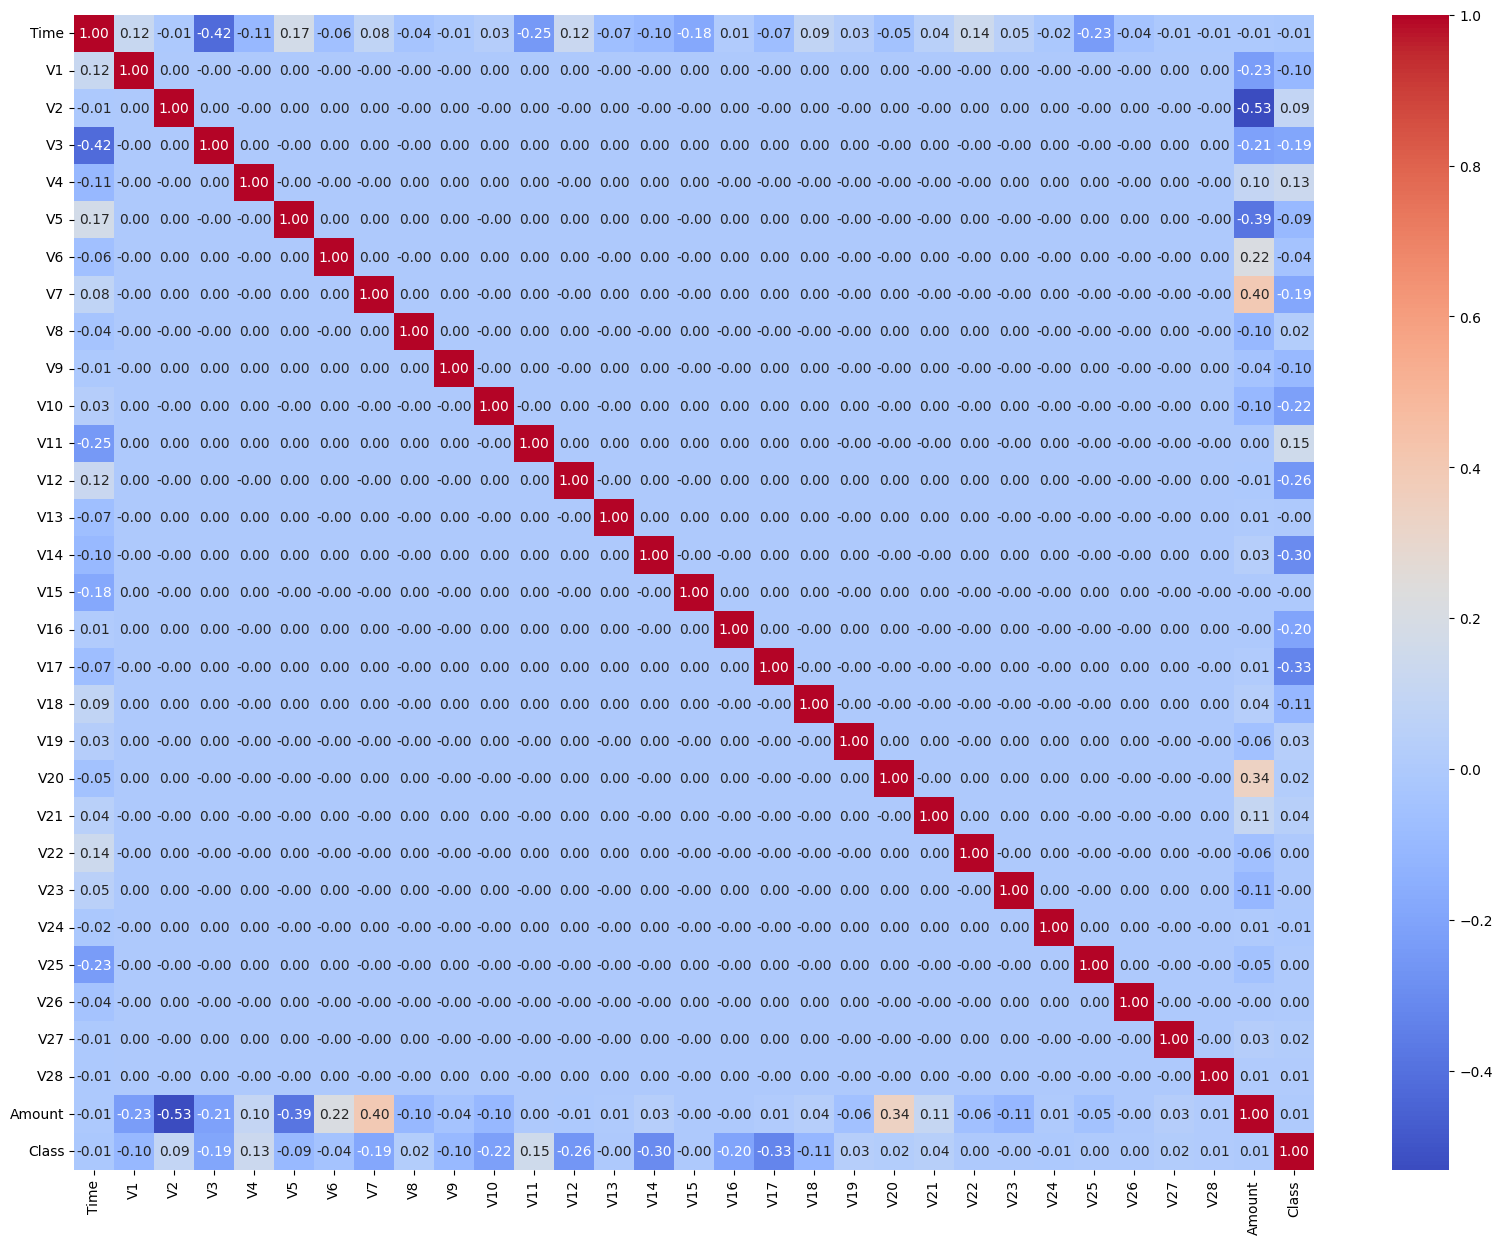

In [9]:
# Correlation - Plotting correlation heatmap
plt.figure(figsize=(20, 15))

dataplot = sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')

# displaying heatmap
plt.show()

- Vì dữ liệu từ V1 đến V28 đã được biến đổi qua phép biển đối PCA, ta có thể thấy giữa các cặp đặc trưng bất kỳ của cột V1 đến V28, không có sự tương đồng
- So sánh độ tương quan giữa các cột từ V1 - V28 với đầu ra dữ liệu, ta thấy độ tương quan từ thấp đến trung bình ở các cặp so sánh này.

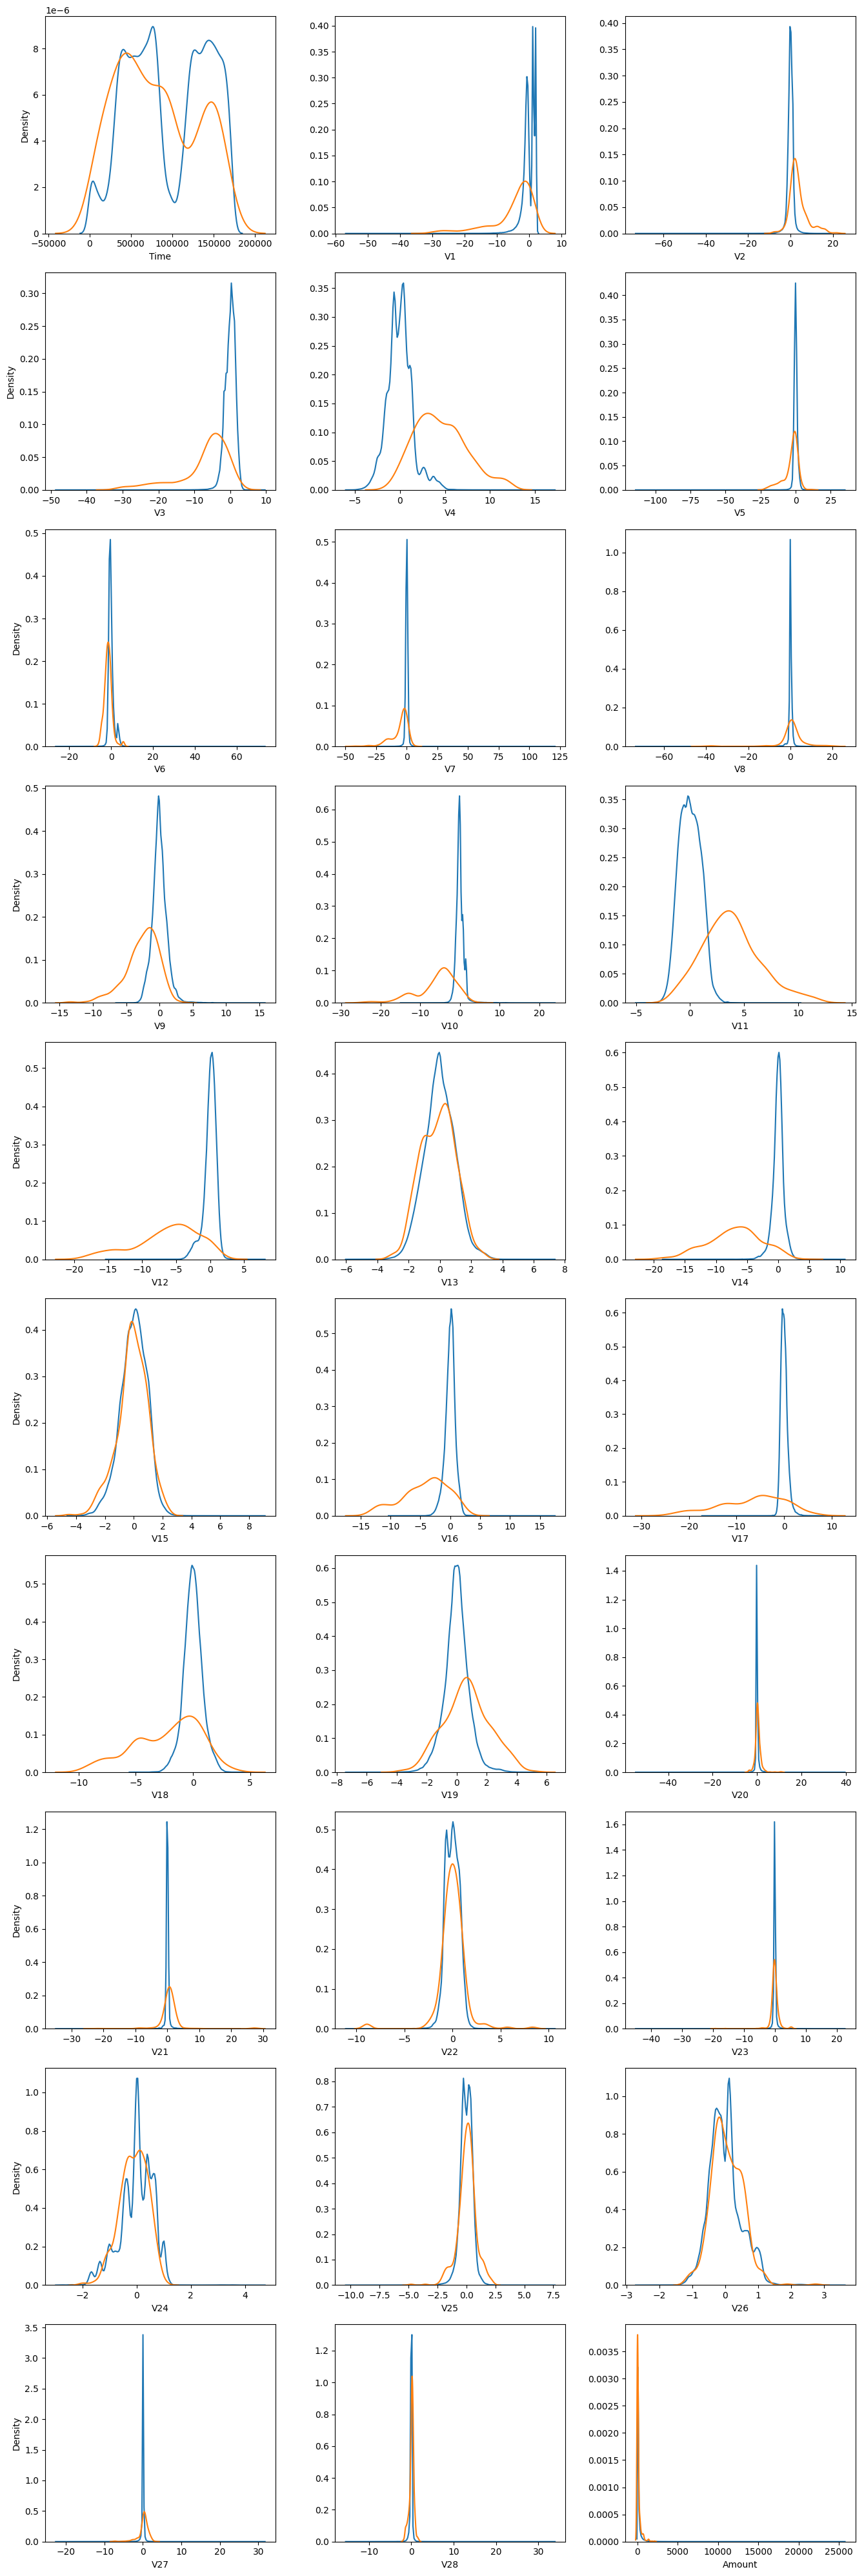

In [10]:
# Comparison of feature distributions for different target classes
# data_val = pd.concat([X_val, y_val], axis = 1)
data_val_0, data_val_1 = df[df['Class'] == 0], df[df['Class'] == 1]

# Drop target column
t = list(df.columns)
t.remove('Class')

cols, ncols = t, 3
nrows = math.ceil(len(cols) / ncols)

# Plot each column by kdeplot
fig, ax = plt.subplots(nrows, ncols, figsize = (4.5 * ncols, 4 * nrows))
for i in range(len(cols)):
    sns.kdeplot(data_val_0[cols[i]], ax = ax[i // ncols, i % ncols])
    sns.kdeplot(data_val_1[cols[i]], ax = ax[i // ncols, i % ncols])
    if i % ncols != 0:
        ax[i // ncols, i % ncols].set_ylabel(" ")
plt.tight_layout()
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

# Apply robust scaler
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Apply Standard scaler
df['scaled_amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))

#Drop column
df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


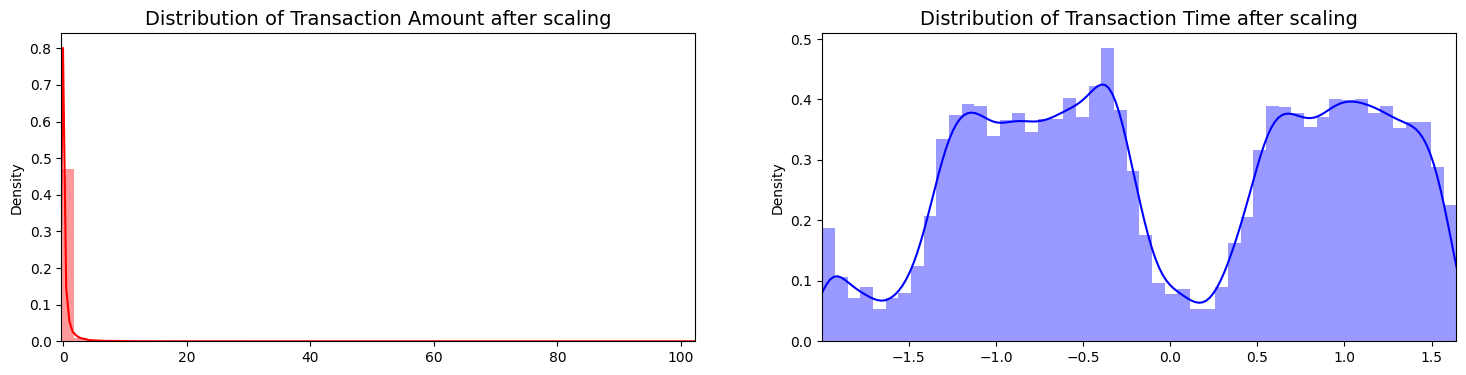

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['scaled_amount'].values
time_val = df['scaled_time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount after scaling', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time after scaling', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

# sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# for train_index, test_index in sss.split(X, y):
#     print("Train:", train_index, "Test:", test_index)
#     original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
#     original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)
# Check the Distribution of the labels


# # Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827075 0.00172925]
[0.99827955 0.00172045]


In [78]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(original_Xtrain, original_ytrain)

prediction = model.predict(original_Xtest)

In [79]:
labels = ['No Fraud', 'Fraud']
print(classification_report(original_ytest, prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56864
       Fraud       0.71      0.69      0.70        98

    accuracy                           1.00     56962
   macro avg       0.85      0.85      0.85     56962
weighted avg       1.00      1.00      1.00     56962



Accuracy:  0.9991222218320986
Precision: 0.8636363636363636
Recall: 0.5816326530612245
F1 Score: 0.6951219512195121


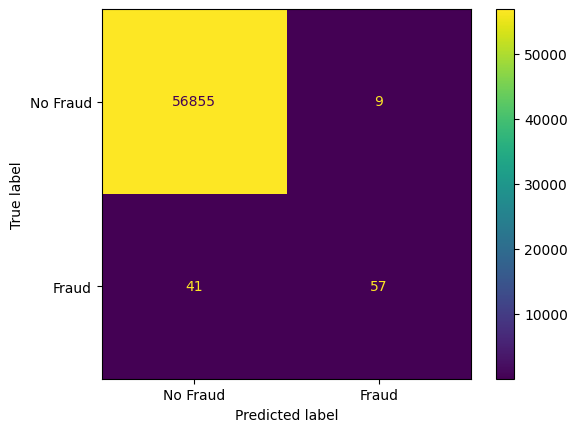

In [19]:
# Metrics
print ("Accuracy: ", accuracy_score(original_ytest, prediction))
print ("Precision:", precision_score(original_ytest,prediction))
print ("Recall:", recall_score(original_ytest, prediction))
print ("F1 Score:", f1_score(original_ytest, prediction))

# Confussion Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(original_ytest, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No Fraud', 'Fraud'])
disp.plot()

In [80]:
from sklearn.metrics import precision_recall_curve, auc

# Lấy giá trị thực tế và dự đoán từ DataFrame
y_true = np.array(original_ytest)
y_scores = prediction

# Tính Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Tính AUPRC
auprc = auc(recall, precision)

print(f'Area Under the Precision-Recall Curve (AUPRC): {auprc}')

Area Under the Precision-Recall Curve (AUPRC): 0.7013687756272412


# Model

## 1. CNN for tabular data

In [21]:
import numpy as np
import subprocess
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow import keras

In [22]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

smote = SMOTE(sampling_strategy='minority', random_state = 42)
nearmiss = NearMiss()

# Apply SMOTE
X_train_smote, y_train_smote = smote.fit_resample(original_Xtrain, original_ytrain.ravel())
# # Apply near miss
# X_train_miss, y_train_miss = nr.fit_sample(X_train, y_train.ravel())

CNN_X_train = X_train_smote.reshape(X_train_smote.shape[0], X_train_smote.shape[1], 1)
CNN_X_test = original_Xtest.reshape(original_Xtest.shape[0], original_Xtest.shape[1], 1)

In [23]:
input_sp = (30, 1)
def create_CNN_model (X):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(64, 2, activation='relu', input_shape = input_sp),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(32, 2, activation='relu'),
        tf.keras.layers.Conv1D(16, 2, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
    return model

# # Create a basic model instance
CNN_model = create_CNN_model(CNN_X_train)

# # Display the model's architecture
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            192       
                                                                 
 dropout (Dropout)           (None, 29, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 32)            4128      
                                                                 
 conv1d_2 (Conv1D)           (None, 27, 16)            1040      
                                                                 
 dropout_1 (Dropout)         (None, 27, 16)            0         
                                                                 
 flatten (Flatten)           (None, 432)               0         
                                                                 
 dense (Dense)               (None, 32)                1

In [24]:
# weights = {0:1, 1:566}
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = CNN_model.fit(original_Xtrain,original_ytrain, validation_split=0.2, epochs=20)

Epoch 1/20
5697/5697 [==============================] - 54s 9ms/step - loss: 0.0102 - accuracy: 0.9982 - val_loss: 0.0044 - val_accuracy: 0.9993
Epoch 2/20
5697/5697 [==============================] - 52s 9ms/step - loss: 0.0045 - accuracy: 0.9993 - val_loss: 0.0031 - val_accuracy: 0.9993
Epoch 3/20
5697/5697 [==============================] - 49s 9ms/step - loss: 0.0044 - accuracy: 0.9992 - val_loss: 0.0041 - val_accuracy: 0.9994
Epoch 4/20
5697/5697 [==============================] - 49s 9ms/step - loss: 0.0045 - accuracy: 0.9993 - val_loss: 0.0038 - val_accuracy: 0.9994
Epoch 5/20
5697/5697 [==============================] - 49s 9ms/step - loss: 0.0049 - accuracy: 0.9992 - val_loss: 0.0032 - val_accuracy: 0.9994
Epoch 6/20
5697/5697 [==============================] - 50s 9ms/step - loss: 0.0043 - accuracy: 0.9993 - val_loss: 0.0038 - val_accuracy: 0.9994
Epoch 7/20
5697/5697 [==============================] - 48s 8ms/step - loss: 0.0048 - accuracy: 0.9993 - val_loss: 0.0033 - val_ac

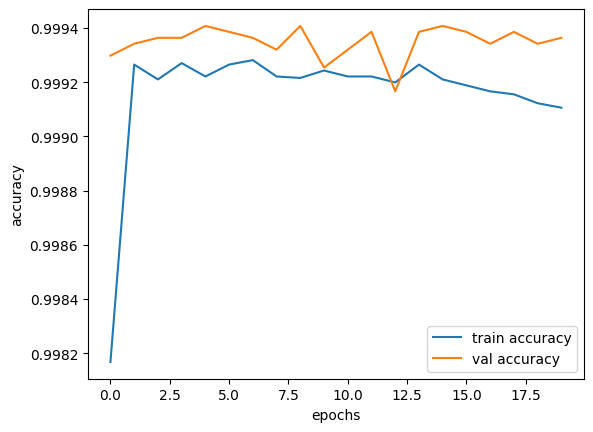

In [26]:
epochs = list(range(20))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [25]:
# Reconstruct output
y_pred = np.around(CNN_model.predict(original_Xtest))

1781/1781 [==============================] - 6s 4ms/step


In [27]:
labels = ['No Fraud', 'Fraud']
print(classification_report(original_ytest, y_pred, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56864
       Fraud       0.85      0.78      0.81        98

    accuracy                           1.00     56962
   macro avg       0.93      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962



Accuracy:  0.999385555282469
Precision: 0.8539325842696629
Recall: 0.7755102040816326
F1 Score: 0.8128342245989305


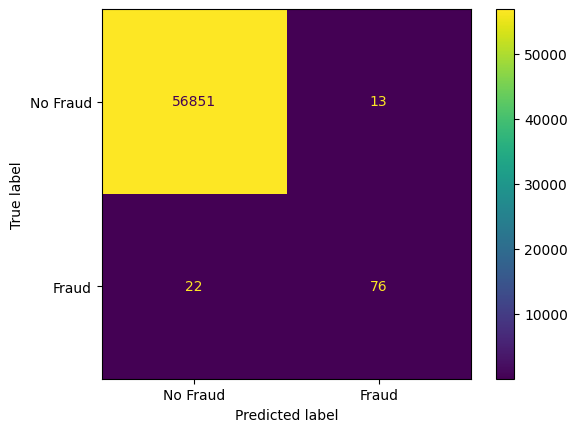

In [28]:
# Metrics
print ("Accuracy: ", accuracy_score(original_ytest, y_pred))
print ("Precision:", precision_score(original_ytest,y_pred))
print ("Recall:", recall_score(original_ytest, y_pred))
print ("F1 Score:", f1_score(original_ytest, y_pred))

# Confussion Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(original_ytest, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No Fraud', 'Fraud'])
disp.plot()

In [29]:
CNN_dir = os.path.join(ROOT, "CNN_model")
CNN_model.save(CNN_dir)

## 2. Random Forest

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from cuml.ensemble import RandomForestClassifier

# sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# # List to append the score and then find the average
# accuracy_lst = []
# precision_lst = []
# recall_lst = []
# f1_lst = []
# auc_lst = []

# model = RandomForestClassifier()
# rand_for_params = {
#  'bootstrap': [True],
#  'max_depth': [10, 30, 50, 60, 80, 90, 100, None],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [5, 10],
#  'n_estimators': [200, 400, 800, 1000]}

# rand_log_reg = GridSearchCV(model, rand_for_params, scoring='accuracy', cv=10, verbose=10)
# rand_log_reg.fit(original_Xtrain, original_ytrain)
# prediction = rand_log_reg.predict(original_Xtest)

# # for train, test in sss.split(original_Xtrain, original_ytrain):
# #     pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
# # #     original_Xtrain[train] = cudf.from_pandas (original_Xtrain[train])
# #     model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
# #     best_est = rand_log_reg.best_estimator_
# #     prediction = best_est.predict(original_Xtrain[test])

# #     accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
# #     precision_lst.append(precision_score(original_ytrain[test], prediction))
# #     recall_lst.append(recall_score(original_ytrain[test], prediction))
# #     f1_lst.append(f1_score(original_ytrain[test], prediction))
# #     auc_lst.append(roc_auc_score(original_ytrain[test], prediction))


In [ ]:
# rand_log_reg.best_params_

NameError: name 'rand_log_reg' is not defined

In [ ]:
# rand_for_prediction = rand_log_reg.predict(original_Xtest)

# # Metrics
# print ("Accuracy: ", accuracy_score(original_ytest, rand_for_prediction))
# print ("Precision:", precision_score(original_ytest,rand_for_prediction))
# print ("Recall:", recall_score(original_ytest, rand_for_prediction))
# print ("F1 Score:", f1_score(original_ytest, rand_for_prediction))

# # Confussion Metrics
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# cm = confusion_matrix(original_ytest, rand_for_prediction)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=['No Fraud', 'Fraud'])
# disp.plot()

In [ ]:
# labels = ['No Fraud', 'Fraud']
# print(classification_report(original_ytest, rand_for_prediction, target_names=labels))

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)
model.fit(original_Xtrain, original_ytrain)
prediction = model.predict(original_Xtest)

In [ ]:
# Metrics
print ("Accuracy: ", accuracy_score(original_ytest, prediction))
print ("Precision:", precision_score(original_ytest, prediction))
print ("Recall:", recall_score(original_ytest, prediction))
print ("F1 Score:", f1_score(original_ytest, prediction))

# Confussion Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(original_ytest, prediction, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No Fraud', 'Fraud'])
disp.plot()

In [ ]:
labels = ['No Fraud', 'Fraud']
print(classification_report(original_ytest, prediction, target_names=labels))

# PySpark Data

## 1. Setup library

In [27]:
import pyspark
import pyarrow
from pyspark.sql import SQLContext

#broadcastTimeout is purposedly set to be large due to development on single machine
conf = pyspark.SparkConf()\
    .setAppName('spark_pipeline')\
    .setMaster('local')\
    .set('spark.driver.memory', '8g')\
    .set('spark.executor.memory', '8g')\
    .set('spark.executor.instances', 4)\
    .set('spark.executor.cores', 4)\
    .set('spark.driver.maxResultSize', '8g')\
    .set('spark.sql.shuffle.partitions', 100)\
    .set('spark.default.parallelism', 200)\
    .set('spark.sql.broadcastTimeout', 36000)\
    .set('spark.kryoserializer.buffer.max', '1024m')\
    .set('spark.sql.execution.arrow.enabled', 'false')\
    .set('spark.dynamicAllocation.enabled', "False")\
    .set('spark.port.maxRetries',30) \
    .set('spark.sql.debug.maxToStringFields', 2000)

sc = pyspark.SparkContext.getOrCreate(conf)
spark = pyspark.sql.SparkSession(sc)
sqlContext = SQLContext.getOrCreate(sc)

In [28]:
import pandas as pd

import pyspark

from pyspark.ml.classification import DecisionTreeClassifier

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import pyspark.sql.functions as f
from pyspark.sql.functions import when, col, regexp_replace
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder

from pyspark.ml.feature import StringIndexer, VectorIndexer, StringIndexerModel, IndexToString
from pyspark.sql import SparkSession

## 2. Load data

In [126]:
data_spark = spark.read.format("csv").load(file,header = 'True',inferSchema='True')

In [127]:
data_spark.show(20)

+----+------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|                V3|                 V4|                 V5|                 V6|                  V7|                 V8|                V9|                V10|               V11|               V12|                V13|                V14|                V15|                V16|                 V17|                V18|                V19|                V20|                 V

In [128]:
# Split into train, test
train_data, test_data = data_spark.randomSplit([0.8, 0.2], seed=42)

# Shape of data
print ("Training shape: ", (train_data.count(), len(train_data.columns)))
print ("Test shape: ", (test_data.count(), len(test_data.columns)))

Training shape:  (227834, 31)
Test shape:  (56973, 31)


In [129]:
# Extract Feature
def vectorizerFunction(dataInput, TargetFieldName):
    if(dataInput.select(TargetFieldName).distinct().count() != 2):
        raise ValueError("Target field must have only 2 distinct classes")
    columnNames = list(dataInput.columns)
    columnNames.remove(TargetFieldName)

    dataInput = dataInput.select((','.join(columnNames)+','+TargetFieldName).split(','))
    assembler=VectorAssembler(inputCols = columnNames, outputCol = 'features')

    # Transform into assembler of PySpark
    pos_vectorized = assembler.transform(dataInput)
    vectorized = pos_vectorized.select('features',TargetFieldName).withColumn('label',pos_vectorized[TargetFieldName]).drop(TargetFieldName)
    return vectorized

X_train = vectorizerFunction(train_data, 'Class')
X_test = vectorizerFunction(test_data, 'Class')

## 3. Model

### 3.1. Baseline - Logistic Regression

In [130]:
from pyspark.ml.classification import LogisticRegression as LogisticRegressionSpark
from pyspark.ml.classification import RandomForestClassifier as RandomForestClassifierSpark

lgr = LogisticRegressionSpark(labelCol='label', featuresCol='features')
model_lgr = lgr.fit(X_train)
model_lgr.transform(X_train)
predictions = model_lgr.transform(X_test)

In [131]:
predictions.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------------------------------------+------------------------------------------+----------+
|features                                                                                                                                                                                                                                                                                                                                                                  

In [132]:
y_pred = predictions.select('prediction').collect()
y_pred_array = [x[0] for x in y_pred]
y = predictions.select('label').collect()
y_array = [x[0] for x in y]
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.90      0.65      0.76        98

    accuracy                           1.00     56973
   macro avg       0.95      0.83      0.88     56973
weighted avg       1.00      1.00      1.00     56973



In [92]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
from pyspark.ml.linalg import DenseVector

# Define UDF to get the maximum value from DenseVector
def get_max_from_vector(vector):
    return float(max(vector))

max_udf = udf(get_max_from_vector, DoubleType())

In [145]:
from sklearn.metrics import precision_recall_curve, auc

# # Get max probability
# predictions = predictions.withColumn("max_proba", max_udf(predictions["probability"]))

# # Get probability of sample
# y_score = predictions.select('max_proba').collect()

# Define a UDF to extract the second element from DenseVector
def get_second_element(probability_vector):
    return float(probability_vector[1])

# Register the UDF
get_second_element_udf = udf(get_second_element, DoubleType())

# Apply the UDF to the DataFrame
predictions = predictions.withColumn('second_element', get_second_element_udf(predictions['probability']))
y_score = predictions.select('second_element').collect()
y_score = np.array([x[0] for x in y_score])

# Tính Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_array, y_score)

# Tính AUPRC
auprc = auc(recall, precision)

print(f'Area Under the Precision-Recall Curve (AUPRC): {auprc}')

Area Under the Precision-Recall Curve (AUPRC): 0.721209221189726


In [142]:
auc = roc_auc_score(y_array, y_score)
print("AUC-ROC:", auc)

AUC-ROC: 0.9600134559318234


In [119]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='label', metricName='areaUnderPR')

# Calculate the AUPRC
auprc = evaluator.evaluate(predictions)
print(f'AUPRC: {auprc:.4f}')

AUPRC: 0.6856


In [120]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='label', metricName='areaUnderROC')

# Calculate the AUC-ROC score
roc_auc = evaluator.evaluate(predictions)
print(f'AUC-ROC: {roc_auc:.4f}')

AUC-ROC: 0.9600


### 3.2. Random Forest - No Sampling

In [64]:
from pyspark.ml.classification import RandomForestClassifier as RandomForestClassifierSpark

model_rf = RandomForestClassifierSpark(labelCol='label',featuresCol='features', seed=42)

train_rf = model_rf.fit(X_train)
train_rf.transform(X_train)

predictions = train_rf.transform(X_test)

In [65]:
y_pred = predictions.select('prediction').collect()
y_pred_array = [x[0] for x in y_pred]
y = predictions.select('label').collect()
y_array = [x[0] for x in y]
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.89      0.73      0.80        98

    accuracy                           1.00     56973
   macro avg       0.94      0.87      0.90     56973
weighted avg       1.00      1.00      1.00     56973



In [69]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='label', metricName='areaUnderPR')

# Calculate the AUPRC
auprc = evaluator.evaluate(predictions)
print(f'AUPRC: {auprc:.4f}')

AUPRC: 0.7614


In [70]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='label', metricName='areaUnderROC')

# Calculate the AUC-ROC score
roc_auc = evaluator.evaluate(predictions)
print(f'AUC-ROC: {roc_auc:.4f}')

AUC-ROC: 0.9511


### 3.2. XGBoost

In [71]:
from xgboost.spark import SparkXGBClassifier

spark_reg_estimator = SparkXGBClassifier(
  features_col="features",
  label_col="label",
  num_workers=2,
)

train_xg = spark_reg_estimator.fit(X_train)
train_xg.transform(X_train)

predictions = train_xg.transform(X_test)

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 2 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


In [72]:
y_pred = predictions.select('prediction').collect()
y_pred_array = [x[0] for x in y_pred]
y = predictions.select('label').collect()
y_array = [x[0] for x in y]
from sklearn.metrics import classification_report
print(classification_report(y_array, y_pred_array))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.96      0.77      0.85        98

    accuracy                           1.00     56973
   macro avg       0.98      0.88      0.93     56973
weighted avg       1.00      1.00      1.00     56973



In [73]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='label', metricName='areaUnderPR')

# Calculate the AUPRC
auprc = evaluator.evaluate(predictions)
print(f'AUPRC: {auprc:.4f}')

AUPRC: 0.7934


In [74]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='label', metricName='areaUnderROC')

# Calculate the AUC-ROC score
roc_auc = evaluator.evaluate(predictions)
print(f'AUC-ROC: {roc_auc:.4f}')

AUC-ROC: 0.9811


### 3.3. Neural Network - CNN

In [146]:
data_spark = spark.read.format("csv").load(file,header = 'True', inferSchema='True')
data_df = pd.read_csv(file)

In [147]:
# Split data
data_test_feature = original_Xtest
data_test_label = original_ytest

# Convert into parquet file
test_df = pd.DataFrame(data_test_feature)
test_df ['features'] =  test_df .values.tolist()
pdf = test_df [['features']]
df = spark.createDataFrame(pdf)

df.write.mode("overwrite").parquet("test_data1")

In [148]:
# Read Parquet file
df = spark.read.parquet("test_data1")
df.show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                                   

In [149]:
CNN_dir = os.path.join(ROOT, "CNN_model")

In [150]:
# Load model
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import array, col, struct
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

def Model_batch_fn():
    import tensorflow as tf
    model = tf.keras.models.load_model(CNN_dir)
    def predict(inputs: np.str_) -> np.ndarray:
#         inputs = np.array(inputs).reshape(inputs.shape[1],1)
        return model.predict(inputs)

    return predict

CNN_sent = predict_batch_udf(Model_batch_fn,
                          return_type=ArrayType(FloatType()),
                          batch_size=16,
                          input_tensor_shapes=[[30, 1]])

In [151]:
# data_test = X_test.withColumn('features_array', to_array('features'))
# data_test = X_test.select('features')

CNN_preds = df.withColumn("preds", CNN_sent(struct(*df.columns))).toPandas()

In [152]:
CNN_preds

,features,preds
0,"[1.1028336180034406, -1.12257389905308, -16.52...",[0.8753330111503601]
1,"[1.726255198224186, -1.0645382612538332, 0.339...",[1.9080935942383803e-08]
2,"[-0.22928872095474692, -1.2493636578300265, 1....",[7.5436996667122e-06]
3,"[-0.34723226367591664, 1.522680364033196, -0.4...",[8.070831972872838e-05]
4,"[-0.34967109625421877, 1.551108561068386, 2.01...",[5.223965217737714e-06]
...,...,...
56957,"[-0.05061424894765971, -0.8126433775983217, -1...",[3.7599285860778764e-05]
56958,"[-0.3132885118893834, 1.282683207285005, -0.23...",[5.216069894231623e-06]
56959,"[-0.32272399530707696, 1.003981586721496, 0.04...",[0.00012091096868971363]
56960,"[-0.3388762635305863, -0.7508594293751759, -0....",[5.81659014642355e-06]


In [153]:
prediction = list()
for item in CNN_preds['preds']:
  prediction.append(np.around(item[0]))

CNN_preds['prediction'] = prediction
CNN_preds

,features,preds,prediction
0,"[1.1028336180034406, -1.12257389905308, -16.52...",[0.8753330111503601],1.0
1,"[1.726255198224186, -1.0645382612538332, 0.339...",[1.9080935942383803e-08],0.0
2,"[-0.22928872095474692, -1.2493636578300265, 1....",[7.5436996667122e-06],0.0
3,"[-0.34723226367591664, 1.522680364033196, -0.4...",[8.070831972872838e-05],0.0
4,"[-0.34967109625421877, 1.551108561068386, 2.01...",[5.223965217737714e-06],0.0
...,...,...,...
56957,"[-0.05061424894765971, -0.8126433775983217, -1...",[3.7599285860778764e-05],0.0
56958,"[-0.3132885118893834, 1.282683207285005, -0.23...",[5.216069894231623e-06],0.0
56959,"[-0.32272399530707696, 1.003981586721496, 0.04...",[0.00012091096868971363],0.0
56960,"[-0.3388762635305863, -0.7508594293751759, -0....",[5.81659014642355e-06],0.0


In [154]:
labels = ['No Fraud', 'Fraud']
y_pred = CNN_preds['prediction'].to_numpy()
print(classification_report(data_test_label, y_pred, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     56864
       Fraud       0.85      0.78      0.81        98

    accuracy                           1.00     56962
   macro avg       0.93      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962



Accuracy:  0.999385555282469
Precision: 0.8539325842696629
Recall: 0.7755102040816326
F1 Score: 0.8128342245989305


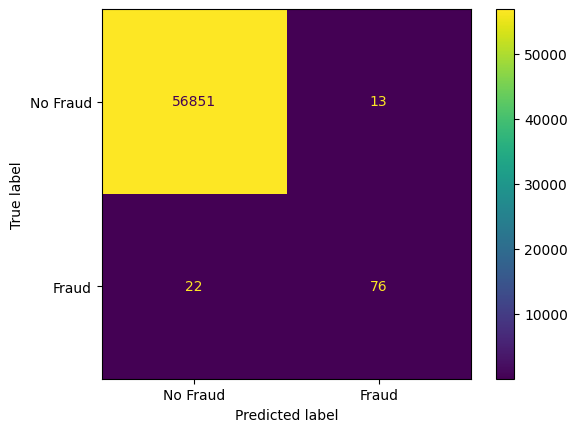

In [155]:
# Metrics
print ("Accuracy: ", accuracy_score(data_test_label, y_pred))
print ("Precision:", precision_score(data_test_label,y_pred))
print ("Recall:", recall_score(data_test_label, y_pred))
print ("F1 Score:", f1_score(data_test_label, y_pred))

# Confussion Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(data_test_label, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['No Fraud', 'Fraud'])
disp.plot()

In [156]:
from sklearn.metrics import precision_recall_curve, auc

# Lấy giá trị thực tế và dự đoán từ DataFrame
y_true = np.array(data_test_label)
y_scores = np.array([item[0] for item in CNN_preds['preds'].to_numpy()])

# Tính Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Tính AUPRC
auprc = auc(recall, precision)

print(f'Area Under the Precision-Recall Curve (AUPRC): {auprc}')

Area Under the Precision-Recall Curve (AUPRC): 0.7750710055822458


In [157]:
# Tính AUC-ROC
auc = roc_auc_score(y_true, y_scores)
print("AUC-ROC:", auc)

AUC-ROC: 0.9844126838974194


In [158]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='label', metricName='areaUnderPR')

# Calculate the AUPRC
auprc = evaluator.evaluate(predictions)
print(f'AUPRC: {auprc:.4f}')

# Initialize the evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='label', metricName='areaUnderROC')

# Calculate the AUC-ROC score
roc_auc = evaluator.evaluate(predictions)
print(f'AUC-ROC: {roc_auc:.4f}')

AUPRC: 0.6856
AUC-ROC: 0.9600
